This notebook tries to replicate what is done [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb)  but in Pytorch.

Reference: [Distill.pub / Differentiable Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer)

In [77]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


import torch

from torchvision import models

import numpy as np

import PIL.Image
import urllib

import matplotlib.pyplot as plt

from pyimgy.optional.torch import *
from netlens.style_transfer import *
from netlens.modules import Normalization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Optional: clearing CUDA memory

In [69]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    from pynvml import *
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print("Total memory:", info.total)
    print("Free memory:", info.free)
    print("Used memory:", info.used)
    
    torch.cuda.memory_allocated()

In [70]:
model = models.googlenet(pretrained=True).to(device)

In [71]:
def load(source):
    if source.startswith('http'):
        source = urllib.request.urlopen(source)
    img = PIL.Image.open(source)
    return np.array(img)

(512, 512, 3) (512, 645, 3)


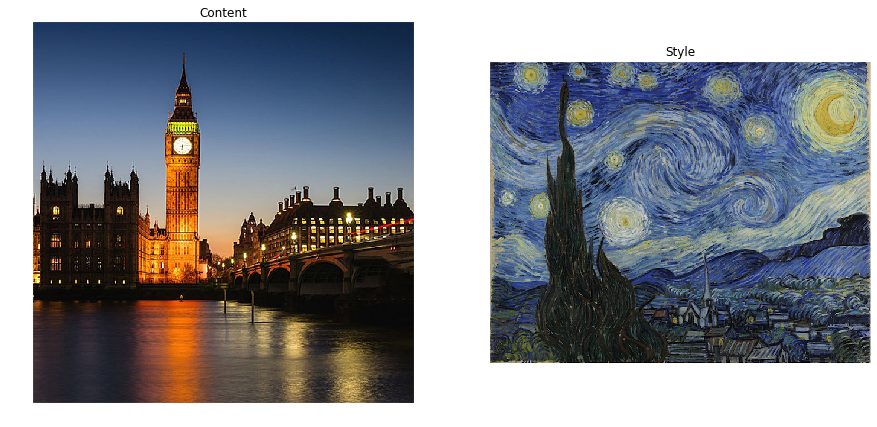

In [72]:
# how to load images from URLs?

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show_images([content_image, style_image], ['Content', 'Style'])

In [73]:
type(content_image)

numpy.ndarray

In [74]:
content_image.shape[:2]

(512, 512)

In [78]:
import torchvision.transforms as T
import netlens.transforms as T2

def transform_inputs(content_image, style_image, zoom=1.0):
    content_tfms = T.Compose([T.ToPILImage(), T2.Zoom(zoom), T.ToTensor()])
    content_input = content_tfms(content_image).unsqueeze(0)
    style_tfms = T.Compose([T.ToPILImage(), T2.Zoom(zoom), T.RandomCrop(content_input.shape[-2:]), T.ToTensor()])
    style_input = style_tfms(style_image).unsqueeze(0)
    return content_input, style_input

In [79]:
content_input, style_input = transform_inputs(content_image, style_image, 0.5)

In [80]:
content_input = content_input.to(device)
style_input = style_input.to(device)

In [81]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [82]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [83]:
arch = FlatModel.from_cnn(cnn) #, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

In [84]:
arch.summary()

    # | LAYER     | MODULE
--------------------------------------------------------------------------------
    0 | conv-0    | Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    1 | relu-0    | ReLU()
    2 | conv-1    | Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    3 | relu-1    | ReLU()
    4 | pool-0    | MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    5 | conv-2    | Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    6 | relu-2    | ReLU()
    7 | conv-3    | Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    8 | relu-3    | ReLU()
    9 | pool-1    | MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   10 | conv-4    | Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   11 | relu-4    | ReLU()
   12 | conv-5    | Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   13 | relu-5    | ReLU()
   14 | conv-6    

In [85]:
style_injects = [f'conv-{i}' for i in range(5)]
content_injects = ['conv-3']

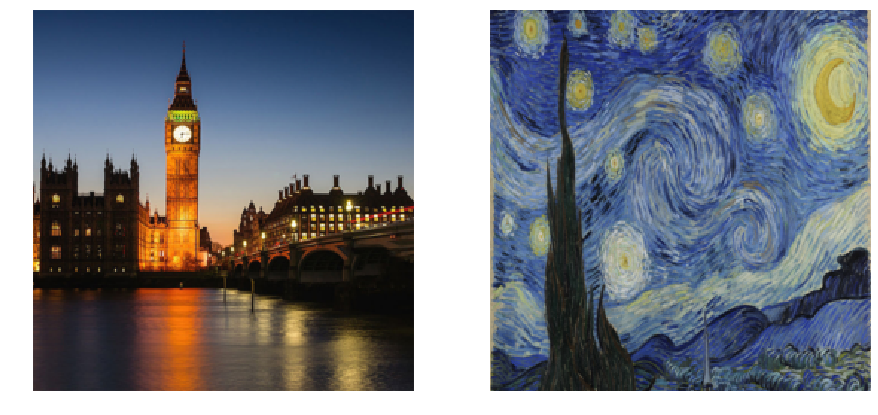

In [86]:
show_images([content_input, style_input])

In [54]:
style_module = StyleTransferModule(arch, content_input, content_injects, style_input, style_injects)

In [89]:
style_module.summary()

    # | LAYER            | MODULE
--------------------------------------------------------------------------------
    0 | conv-0           | Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    1 | style_loss-0     | FeatureLoss()
    2 | relu-0           | ReLU()
    3 | conv-1           | Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    4 | style_loss-1     | FeatureLoss()
    5 | relu-1           | ReLU()
    6 | pool-0           | MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    7 | conv-2           | Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    8 | style_loss-2     | FeatureLoss()
    9 | relu-2           | ReLU()
   10 | conv-3           | Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   11 | style_loss-3     | FeatureLoss()
   12 | content_loss-3   | FeatureLoss()
   13 | relu-3           | ReLU()
   14 | pool-1           | MaxPool2d(kernel_size=2, stride=2, paddin

In [90]:
len(style_module.layers)

17

In [91]:
[m.target.sum() for k, m in style_module.layers.items() if k.startswith('style_loss')]

[tensor(0.0251),
 tensor(3.6283),
 tensor(14.3352),
 tensor(120.7510),
 tensor(345.1545)]

In [92]:
[m.target.sum() for k, m in style_module.layers.items() if k.startswith('content_loss')]

[tensor(-1384654.1250)]

In [93]:
class STCallback(OptVisCallback):
    def on_step_end(self, optvis, img, *args, **kwargs):
        if optvis.is_step_to_show():
            print(f'Style loss={optvis.objective.style_loss}, Content loss={optvis.objective.content_loss}, TV loss={optvis.objective.tv_loss}')

In [94]:
style_obj = StyleTransferObjective(style_module, style_weight=100000, content_weight=1, tv_weight=0)

In [95]:
import torch.optim
from netlens.visualization.render import *

optvis = OptVis(style_module, style_obj, optim=optim.LBFGS)

In [96]:
content_input.shape

torch.Size([1, 3, 256, 256])

In [97]:
# we need to pre-prend the "layer" of the parameterization
from netlens.visualization import param

image_param = param.ImageParam(im_initial=content_input, fft=True, decorrelate=True)

Run [50], loss=9.6089


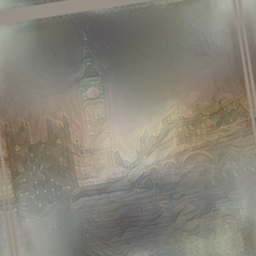

Style loss=3.7733027935028076, Content loss=5.835635662078857, TV loss=0.0
Run [100], loss=6.9653


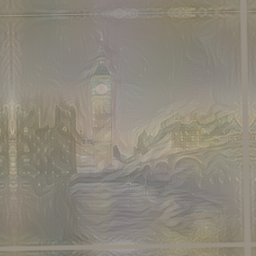

Style loss=1.513028621673584, Content loss=5.4522624015808105, TV loss=0.0
Run [150], loss=7.0907


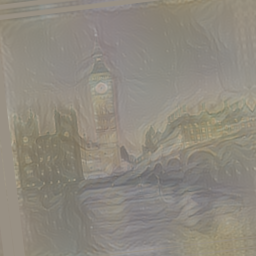

Style loss=1.3447374105453491, Content loss=5.745966911315918, TV loss=0.0
Run [200], loss=7.4984


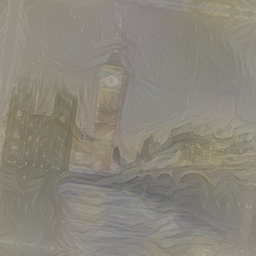

Style loss=2.0217456817626953, Content loss=5.476661205291748, TV loss=0.0


In [98]:
output = optvis.vis(image_param, thresh=(50,100,150,200), transform=True, in_closure=True, show=True,
                    callback=STCallback())

In [100]:
raw_output = image_param()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


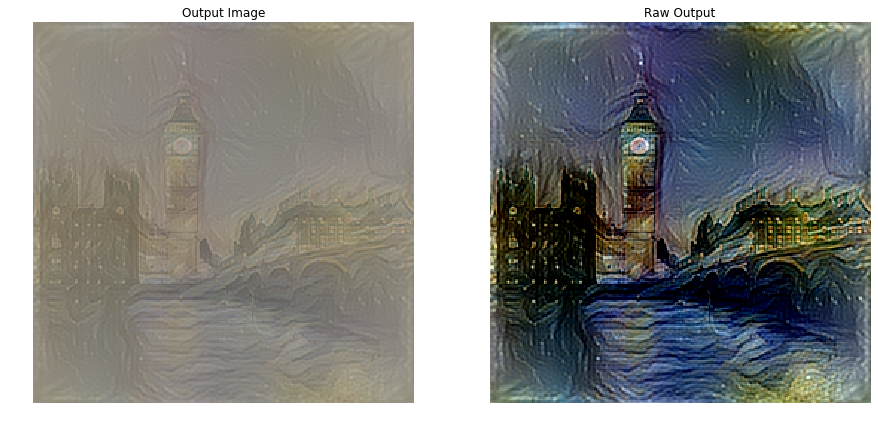

In [101]:
show_images([output, raw_output], ['Output Image', 'Raw Output'])

In [103]:
raw_output.min(), raw_output.max()

(tensor(-0.5317, grad_fn=<MinBackward1>),
 tensor(1.1748, grad_fn=<MaxBackward1>))

In [105]:
output.min(), output.max()

(tensor(0.3081, grad_fn=<MinBackward1>),
 tensor(0.7251, grad_fn=<MaxBackward1>))